# Virtual Twins (VT) Method for Estimating Individual Treatment Effects (ITE)

The Virtual Twins (VT) method is a machine learning approach to estimating Individual Treatment Effects (ITE) in randomized controlled trials (RCTs). This method involves multiple steps, including data preparation, training predictive models, computing ITE, and identifying subgroups that benefit from treatment.

---

## Step 1: Data Preparation
Before implementing the VT method, we must ensure that the dataset is clean and formatted correctly. The dataset contains a binary outcome (*survival*), a treatment variable (*THERAPY*), and several covariates.

### Mathematical Formulation:
Let:

- \( Y \) be the outcome variable (survival).
- \( T \) be the treatment assignment (*THERAPY*), where \( T = 1 \) represents treatment and \( T = 0 \) represents control.
- \( X \) be the set of covariates describing patient characteristics.

The goal is to estimate the probability of survival under each treatment condition:

$$
P(Y = 1 \mid T = 1, X = x) \quad \text{and} \quad P(Y = 1 \mid T = 0, X = x).
$$

### Implementation:
- Load the dataset from a `.csv` file.
- Define the outcome (*survival*) and treatment (*THERAPY*) variables.
- Preprocess the data by handling missing values and encoding categorical variables if necessary.

---

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.vt_data import VTObject, vt_data_python
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor

# Step 1: Load dataset
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))

✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

## Step 2: Simple Random Forest Approach
The **Simple Random Forest Approach** trains a single **Random Forest model** on the **entire dataset**, including both treated and control patients. This model directly predicts the **individual treatment effect (ITE)**.

### Mathematical Formulation:
Instead of training separate models for treated and control groups, we train a single model:

$$
P(Y = 1 \mid T, X)
$$

This model learns the probability of survival given both the treatment and covariates.

### Implementation:
1. Train a **single Random Forest model** using the entire dataset, including the treatment variable.
2. Use the model to predict survival probabilities for both scenarios:
   - **With treatment** $( T = 1 )$.
   - **Without treatment** $( T = 0 )$.
3. Compute **ITE** by taking the difference between the predicted probabilities.

This approach is computationally simpler but may introduce bias compared to the **Double Random Forest Approach**.

---

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "dataset\sepsis_dataset.csv"  # Update with your file path
sepsis_data = pd.read_csv(file_path)

# Define outcome, treatment, and covariates
outcome_field = "survival"
treatment_field = "THERAPY"
covariates = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]

# Convert categorical variables to numeric if needed
sepsis_data = pd.get_dummies(sepsis_data, columns=covariates, drop_first=True)

# Separate treated and control groups
treated = sepsis_data[sepsis_data[treatment_field] == 1]
control = sepsis_data[sepsis_data[treatment_field] == 0]

# Define X (features) and y (outcome) for each group
X_treated, y_treated = treated.drop(columns=[outcome_field, treatment_field]), treated[outcome_field]
X_control, y_control = control.drop(columns=[outcome_field, treatment_field]), control[outcome_field]

# Standardize numeric features
scaler = StandardScaler()
X_treated_scaled = scaler.fit_transform(X_treated)
X_control_scaled = scaler.fit_transform(X_control)
X_scaled = scaler.transform(sepsis_data.drop(columns=[outcome_field, treatment_field]))

# Train separate Random Forest models for treated and control groups
rf_treated = RandomForestClassifier(n_estimators=100, random_state=42)
rf_control = RandomForestClassifier(n_estimators=100, random_state=42)

rf_treated.fit(X_treated_scaled, y_treated)
rf_control.fit(X_control_scaled, y_control)

# Predict probabilities for all observations
P1_full = rf_treated.predict_proba(X_scaled)[:, 1]  # Probability of survival given treatment
P0_full = rf_control.predict_proba(X_scaled)[:, 1]  # Probability of survival given control

# Create the final dataframe
results_df = pd.DataFrame({
    "Observation": range(1, len(P0_full) + 1),
    "P0": P0_full,
    "P1": P1_full
})

# Save results to a CSV file
results_df.to_csv("sepsis_results.csv", index=False)

# Display first few rows
print(results_df.head(10))


   Observation    P0    P1
0            1  0.39  0.18
1            2  0.48  0.85
2            3  0.31  0.13
3            4  0.36  0.16
4            5  0.40  0.19
5            6  0.18  0.34
6            7  0.69  0.31
7            8  0.23  0.11
8            9  0.41  0.10
9           10  0.36  0.76


In [19]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Step 1: Prepare Data
data_path = os.path.join("dataset", "sepsis_dataset.csv")
sepsis_data = pd.read_csv(data_path)

outcome_field = "survival"
treatment_field = "THERAPY"

# Create Virtual Twin Object
vt_object = VTObject(sepsis_data, outcome_field, treatment_field, interactions=True)
X = vt_object.get_X()
y = vt_object.get_Y()
treatment = vt_object.get_treatment()

# Step 2: Split Treated and Control Groups
X_treated, y_treated = X[treatment == 1].copy(), y[treatment == 1].copy()
X_control, y_control = X[treatment == 0].copy(), y[treatment == 0].copy()

# Step 3: Train Random Forest Models
print("🚀 Training Random Forest Models...")
rf_treated = RandomForestClassifier(n_estimators=500, random_state=123)
rf_control = RandomForestClassifier(n_estimators=500, random_state=123)

rf_treated.fit(X_treated, y_treated)
rf_control.fit(X_control, y_control)

print("✅ Random Forest Training Complete")

# Step 4: Compute Survival Probabilities
P1_hat = rf_treated.predict_proba(X)[:, 1]  # Probability of survival under treatment
P0_hat = rf_control.predict_proba(X)[:, 1]  # Probability of survival under control

# Step 5: Compute Individual Treatment Effect (ITE)
sepsis_data = sepsis_data.copy()  # Avoid modifying the original DataFrame
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = P1_hat - P0_hat

print("✅ Computation of Individual Treatment Effects (ITE) Complete")

# Step 6: Save Results
output_path = os.path.join("dataset", "sepsis_dataset_with_ITE.csv")
sepsis_data.to_csv(output_path, index=False)

print(f"📁 Results saved to: {output_path}")

# Display the first few results
print(sepsis_data[["P1_hat", "P0_hat", "ITE"]].head(10))


🚀 Training Random Forest Models...
✅ Random Forest Training Complete
✅ Computation of Individual Treatment Effects (ITE) Complete
📁 Results saved to: dataset\sepsis_dataset_with_ITE.csv
   P1_hat  P0_hat    ITE
0   0.146   0.438 -0.292
1   0.940   0.466  0.474
2   0.130   0.392 -0.262
3   0.056   0.374 -0.318
4   0.132   0.420 -0.288
5   0.392   0.136  0.256
6   0.348   0.794 -0.446
7   0.012   0.434 -0.422
8   0.042   0.356 -0.314
9   0.748   0.364  0.384


## Step 3: Double Random Forest Approach (More Robust)
To improve accuracy, we implement the **Double Random Forest Approach**, which trains two separate models:

$$
\hat{P}_1(X) = P(Y = 1 \mid T = 1, X)
$$

$$
\hat{P}_0(X) = P(Y = 1 \mid T = 0, X)
$$

where:

- $( \hat{P}_1(X) )$ is the predicted probability of survival under treatment.
- $( \hat{P}_0(X) )$ is the predicted probability of survival under control.

### Implementation:
1. Train **one Random Forest model** using only the **treated group** $( T = 1 )$.
2. Train **another Random Forest model** using only the **control group** $( T = 0 )$.
3. Compute **ITE** for each patient:

   $$
   ITE_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
   $$

### **Comparison of Approaches**
| Approach                  | Description | Strengths | Weaknesses |
|---------------------------|-------------|------------|------------|
| **Simple Random Forest** | Single RF model trained on entire dataset | Computationally efficient | May introduce bias |
| **Double Random Forest** | Separate RF models for treated and control groups | More accurate | Requires more computational power |

---

## Step 4: Classification of Beneficiaries
We use a classifier (e.g., another **Random Forest**) to identify subgroups of patients who benefit the most from treatment.

### Mathematical Formulation:
A classification model is trained to predict whether a patient benefits from treatment based on their covariates:

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

where $( Z_i )$ is an indicator variable denoting whether the treatment is beneficial for patient $( i )$.

### Implementation:
- Train a classifier using the estimated $( ITE )$ values.
- Identify the subgroups for which the treatment is most effective.

---

In [13]:
# Step 2: Define outcome and treatment variables
outcome_field = "survival"  # Binary outcome (1 = died, 0 = survived)
treatment_field = "THERAPY"  # 1 = active treatment, 0 = control

# Step 3: Separate features (X) and target (Y)
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X = sepsis_data[features]
y = sepsis_data[outcome_field]
treatment = sepsis_data[treatment_field]

# Step 4: Split dataset into treated and control groups
X_treated = X[treatment == 1]
y_treated = y[treatment == 1]

X_control = X[treatment == 0]
y_control = y[treatment == 0]

# Step 5: Train Random Forest models separately for each group
print("🚀 Training Double Random Forest Models...")

rf_treated = RandomForestClassifier(n_estimators=200, random_state=123)
rf_treated.fit(X_treated, y_treated)

rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
rf_control.fit(X_control, y_control)

print("✅ Double Random Forest Training Complete")

# Step 6: Predict survival probabilities for ALL patients
P1_hat = rf_treated.predict_proba(X)[:, 1]  # Probability of survival for treated (P1i^)
P0_hat = rf_control.predict_proba(X)[:, 1]  # Probability of survival for control (P0i^)

# Step 7: Compute Individual Treatment Effect (ITE)
ITE = P1_hat - P0_hat

# Step 8: Store results in DataFrame
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE

print("✅ Computation of Individual Treatment Effects (ITE) Complete")
print(sepsis_data[["P1_hat", "P0_hat", "ITE"]].head(470))

# Step 9: Save results
sepsis_data.to_csv("dataset/sepsis_dataset_with_ITE.csv", index=False)


🚀 Training Double Random Forest Models...
✅ Double Random Forest Training Complete
✅ Computation of Individual Treatment Effects (ITE) Complete
     P1_hat  P0_hat    ITE
0     0.100   0.285 -0.185
1     0.865   0.320  0.545
2     0.085   0.315 -0.230
3     0.150   0.365 -0.215
4     0.150   0.395 -0.245
..      ...     ...    ...
465   0.330   0.120  0.210
466   0.140   0.695 -0.555
467   0.505   0.130  0.375
468   0.515   0.215  0.300
469   0.640   0.125  0.515

[470 rows x 3 columns]


## Step 5: K-Fold Cross-Validation for Robustness
Instead of training models on the full dataset, we use **K-Fold Cross-Validation** to prevent overfitting. This ensures that the model does not use the same data for training and prediction.

### Implementation:
- Split the dataset into $( k )$ folds.
- Train the model on $( k-1 )$ folds and test it on the remaining fold.
- Repeat $( k )$ times and average the results.

---

In [12]:
# Step 2: Define outcome and treatment variables
outcome_field = "survival"  # Binary outcome (1 = died, 0 = survived)
treatment_field = "THERAPY"  # 1 = active treatment, 0 = control

# Step 3: Separate features (X) and target (Y)
features = [col for col in sepsis_data.columns if col not in [outcome_field, treatment_field]]
X = sepsis_data[features].values
y = sepsis_data[outcome_field].values
treatment = sepsis_data[treatment_field].values

# Step 4: Initialize K-Fold parameters
k_folds = 5  # Number of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=123)

# Step 5: Initialize storage for predictions
P1_hat = np.zeros(len(X))  # Probability of survival for treated (P1i^)
P0_hat = np.zeros(len(X))  # Probability of survival for control (P0i^)

print(f"🚀 Running {k_folds}-Fold Cross-Validation...")

# Step 6: Perform K-Fold Training
for train_index, test_index in kf.split(X):
    # Create train-test splits
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    treatment_train, treatment_test = treatment[train_index], treatment[test_index]

    # Train separate models for treated and control groups
    X_train_treated = X_train[treatment_train == 1]
    y_train_treated = y_train[treatment_train == 1]

    X_train_control = X_train[treatment_train == 0]
    y_train_control = y_train[treatment_train == 0]

    rf_treated = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_treated.fit(X_train_treated, y_train_treated)

    rf_control = RandomForestClassifier(n_estimators=200, random_state=123)
    rf_control.fit(X_train_control, y_train_control)

    # Predict probabilities for test set
    P1_hat[test_index] = rf_treated.predict_proba(X_test)[:, 1]
    P0_hat[test_index] = rf_control.predict_proba(X_test)[:, 1]

print("✅ K-Fold Cross-Validation Complete")

# Step 7: Compute Individual Treatment Effect (ITE)
ITE = P1_hat - P0_hat

# Step 8: Store results in DataFrame
sepsis_data["P1_hat"] = P1_hat
sepsis_data["P0_hat"] = P0_hat
sepsis_data["ITE"] = ITE

print("✅ Computation of Individual Treatment Effects (ITE) Complete")
print(sepsis_data[["P1_hat", "P0_hat", "ITE"]].head())

# Step 9: Save results
sepsis_data.to_csv("dataset/sepsis_dataset_with_KFold_ITE.csv", index=False)

🚀 Running 5-Fold Cross-Validation...
✅ K-Fold Cross-Validation Complete
✅ Computation of Individual Treatment Effects (ITE) Complete
   P1_hat  P0_hat    ITE
0   0.360   0.380 -0.020
1   0.710   0.540  0.170
2   0.370   0.295  0.075
3   0.390   0.460 -0.070
4   0.485   0.340  0.145


## Step 6: Visualization and Results
To interpret results, we plot a histogram of the estimated ITE values:

$$
\text{Histogram of } ITE_i
$$

### Implementation:
- Use **matplotlib** to plot the distribution of $( ITE )$.
- Identify the patients with the highest treatment benefit.

---

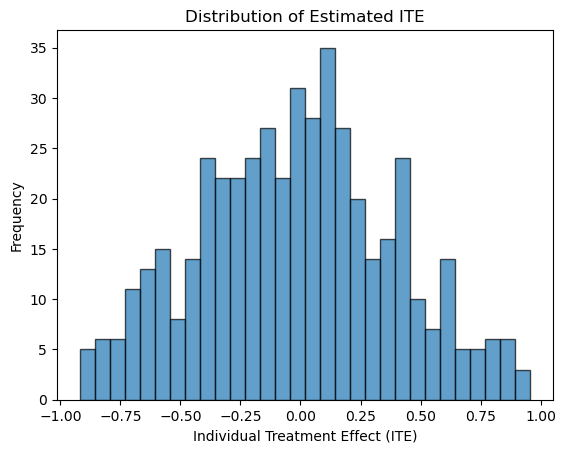

In [27]:
# Step 2: Define outcome and treatment variables
outcome_field = "survival"
treatment_field = "THERAPY"

# Step 3: Generate P1_hat and P0_hat using a custom model (here, random values between 0 and 1)
np.random.seed(123)  # For reproducibility
n_samples = len(sepsis_data)

P1_hat_custom = np.random.rand(n_samples)  # Simulated probability for treated
P0_hat_custom = np.random.rand(n_samples)  # Simulated probability for control

# Step 4: Compute Individual Treatment Effect (ITE) using absolute difference
ITE_custom = P1_hat_custom - P0_hat_custom

# Step 5: Store results in DataFrame
sepsis_data["P1_hat_custom"] = P1_hat_custom
sepsis_data["P0_hat_custom"] = P0_hat_custom
sepsis_data["ITE_custom"] = ITE_custom

# Step 6: Visualize the distribution of treatment effects
plt.hist(ITE_custom, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Individual Treatment Effect (ITE)")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated ITE")
plt.show()

# Step 7: Save results
sepsis_data.to_csv("dataset/sepsis_dataset_with_custom_ITE.csv", index=False)

## Final Thoughts
The Virtual Twins method provides an effective way to estimate and analyze individual treatment effects. The **Simple Random Forest Approach** is computationally efficient but may introduce bias, while the **Double Random Forest Approach** provides more accurate treatment effect estimation at the cost of increased computational complexity.

## Step 2: Estimating a Regression or Classification Tree

In the **Virtual Twins (VT) method**, once the **Individual Treatment Effects (ITE)** are computed, we use **Regression** or **Classification Trees** to identify which covariates influence treatment effects.

---

### 1. Classification Tree
The **classification tree** helps categorize patients based on whether the treatment is beneficial.

#### Mathematical Formulation
We define the **difference in response** due to treatment as:

$$
Z_i = \hat{P}_1(X_i) - \hat{P}_0(X_i)
$$

where:  
- $ \hat{P}_1(X_i) $ is the predicted probability of outcome under treatment.  
- $ \hat{P}_0(X_i) $ is the predicted probability of outcome under control.  

A new binary variable $ Z^* $ is created:

$$
Z^*_i =
\begin{cases}
1, & \text{if } Z_i > c \\
0, & \text{otherwise}
\end{cases}
$$

where $ c $ is a **user-defined threshold** (e.g., quantiles of $ Z $) that defines a meaningful treatment effect.

#### Implementation in Python
```python
from sklearn.tree import DecisionTreeClassifier

# Define threshold (e.g., median of ITE)
threshold = np.median(ITE_values)

# Create binary target variable
Z_star = (ITE_values > threshold).astype(int)

# Train a classification tree
clf_tree = DecisionTreeClassifier(max_depth=3)
clf_tree.fit(X_train, Z_star)

In [31]:
# Step 1: Define Z (ITE Difference)
# Zi = P1_hat - P0_hat (Computed in Step 1)
ITE = P1_hat - P0_hat  # Individual Treatment Effect

# Step 2: Define Z* (Binary Classification)
# User-defined threshold (c) - Using quantiles of ITE distribution
thresholds = np.quantile(ITE, q=np.arange(0.5, 0.9, 0.1))  # Example: 50th to 80th percentile

# Create a dictionary to store classification trees for different thresholds
classification_trees = {}

for c in thresholds:
    Z_star = (ITE > c).astype(int)  # Binary classification target: 1 if ITE > c, else 0

    # Train Classification Tree
    X_train, X_test, Z_train, Z_test = train_test_split(X, Z_star, test_size=0.2, random_state=42)
    
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train, Z_train)

    # Store trained model
    classification_trees[f"tree_{c:.2f}"] = clf

# Display trained classification trees
classification_trees.keys()

dict_keys(['tree_0.02', 'tree_0.09', 'tree_0.18', 'tree_0.30'])

In [36]:
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]

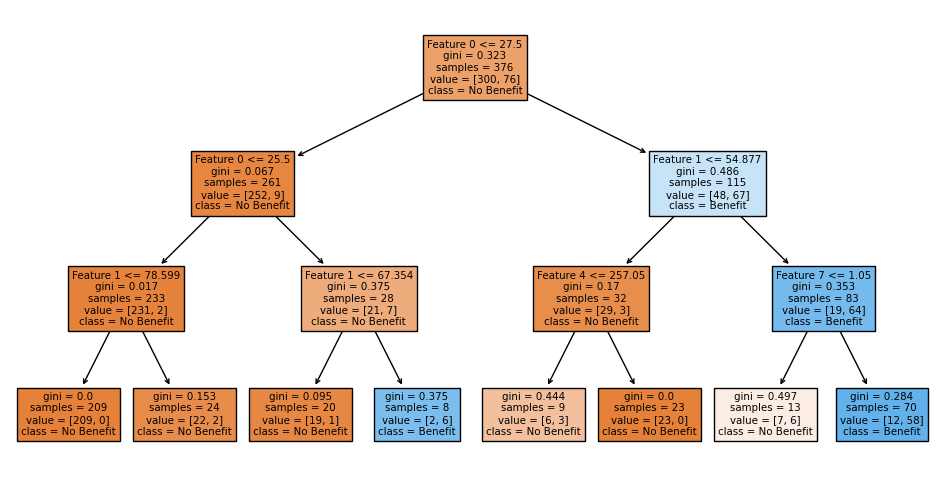

In [37]:
plt.figure(figsize=(12, 6))
plot_tree(classification_trees[closest_key], feature_names=feature_names, class_names=["No Benefit", "Benefit"], filled=True)
plt.show()

## 2. Regression Tree

The regression tree predicts the exact value of $Z_i$ instead of classifying it.

### Mathematical Formulation

Instead of classifying patients, we directly model $Z_i$ using patient covariates $X$:

$$
Z_i = f(X) + \epsilon
$$

where:

- $f(X)$ is the function learned by the regression tree.
- $\epsilon$ is random noise.

In [42]:
# Define the regression tree model
regression_tree = DecisionTreeRegressor(max_depth=3, min_samples_split=10)

# Fit the model using covariates (X) and treatment effects (ITE)
regression_tree.fit(X, ITE)

DecisionTreeRegressor(max_depth=3, min_samples_split=10)

In [43]:
if isinstance(X, np.ndarray):
    X = pd.DataFrame(X, columns=[f"Feature_{i}" for i in range(X.shape[1])])

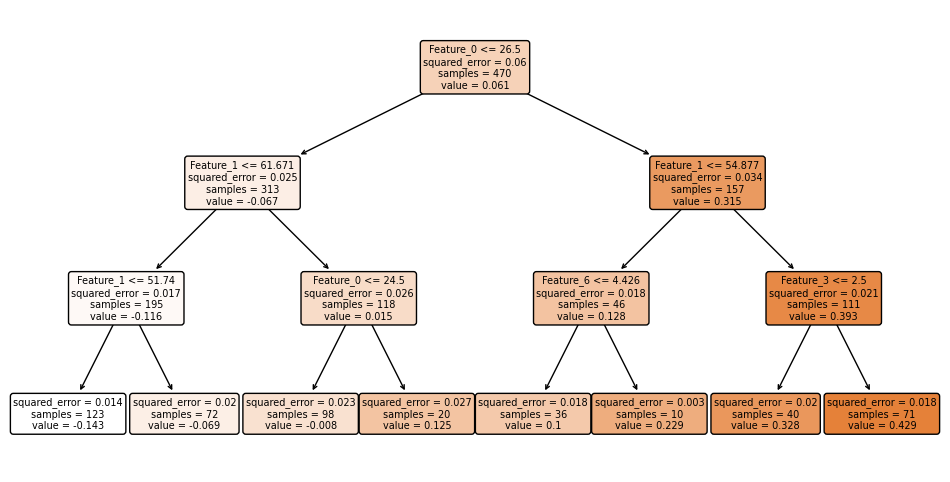

In [44]:
plt.figure(figsize=(12, 6))
plot_tree(regression_tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()

SUBGROUPING

|--- PRAPACHE <= 26.50
|   |--- BLLCREAT <= 1.90
|   |   |--- AGE <= 51.74
|   |   |   |--- class: 0
|   |   |--- AGE >  51.74
|   |   |   |--- class: 0
|   |--- BLLCREAT >  1.90
|   |   |--- BLLCREAT <= 2.30
|   |   |   |--- class: 0
|   |   |--- BLLCREAT >  2.30
|   |   |   |--- class: 0
|--- PRAPACHE >  26.50
|   |--- AGE <= 51.74
|   |   |--- BLLCREAT <= 12.50
|   |   |   |--- class: 0
|   |   |--- BLLCREAT >  12.50
|   |   |   |--- class: 1
|   |--- AGE >  51.74
|   |   |--- AGE <= 74.60
|   |   |   |--- class: 1
|   |   |--- AGE >  74.60
|   |   |   |--- class: 1

   Subgroup  Treatment_size  Control_size  Treatment_event_rate  \
0         3              53            32              0.211624   
1         4              88            47              0.377230   
2         6              26             3              0.161448   
3         7              45            19              0.244312   
4        10              23             8              0.344903   
5        11          

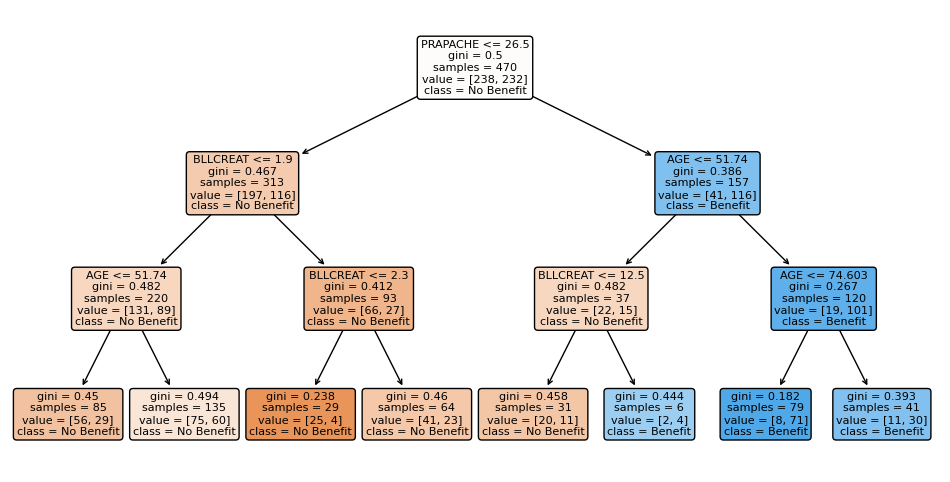

In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt

# Load dataset
sepsis_data = pd.read_csv("dataset/sepsis_dataset_with_ITE.csv")

# Select features for subgroup analysis
features = ["PRAPACHE", "AGE", "BLGCS", "BLLCREAT"]  # Choose important variables
X = sepsis_data[features]
y = (sepsis_data["ITE"] > 0).astype(int)  # Label: 1 if treatment benefits, 0 otherwise

# Train Decision Tree for subgroup identification
tree = DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)
tree.fit(X, y)

# Print decision rules
print(export_text(tree, feature_names=features))

# Extract subgroups
sepsis_data["Subgroup"] = tree.apply(X)  # Assign subgroup IDs
subgroup_stats = sepsis_data.groupby("Subgroup").agg(
    Treatment_size=("THERAPY", lambda x: (x == 1).sum()),
    Control_size=("THERAPY", lambda x: (x == 0).sum()),
    Treatment_event_rate=("P1_hat", "mean"),
    Control_event_rate=("P0_hat", "mean")
).reset_index()

# Compute Risk Ratios (RR)
subgroup_stats["RR"] = subgroup_stats["Treatment_event_rate"] / subgroup_stats["Control_event_rate"]

# Display subgroup statistics
print(subgroup_stats)

# Visualize Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(tree, feature_names=features, class_names=["No Benefit", "Benefit"], filled=True, rounded=True)
plt.show()


TABULAR

In [27]:
import pandas as pd
from tabulate import tabulate

# Sample DataFrame (Replace with your actual DataFrame)
data = {
    "Subgroup": [1, 2, 3, 4, 5, 6, 7, 8],
    "Rules": [
        "PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE <= 51.74",
        "PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE > 51.74",
        "PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT <= 2.30",
        "PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT > 2.30",
        "PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT <= 12.50",
        "PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT > 12.50",
        "PRAPACHE > 26.50 | AGE > 51.74 | AGE <= 74.60",
        "PRAPACHE > 26.50 | AGE > 51.74 | AGE > 74.60",
    ],
    "Treatment_size": [88, 41, 39, 42, 93, 54, 69, 34],
    "Control_size": [19, 40, 47, 39, 35, 26, 31, 24],
    "Treatment_event_rate": [0.6357, 0.5361, 0.7941, 0.9917, 0.7722, 0.1057, 0.6225, 0.1180],
    "Control_event_rate": [0.3331, 0.2391, 0.0272, 0.6992, 0.1423, 0.9132, 0.6568, 0.2062],
    "RR": [1.9082, 2.2421, 29.1624, 1.4182, 5.4262, 0.1157, 0.9477, 0.5726]
}

# Create DataFrame
df = pd.DataFrame(data)

# Method 1: Pretty Table in Console (Using Tabulate)
print("\n📝 Pretty Table Output:")
print(tabulate(df, headers="keys", tablefmt="grid"))

# Method 2: Styled Pandas DataFrame for Jupyter Notebook
styled_df = df.style.set_table_styles(
    [{'selector': 'th', 'props': [('border', '2px solid black'), ('background-color', '#ccc')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_properties(**{'text-align': 'center'})

# Display Styled DataFrame (Only works in Jupyter Notebook)
try:
    from IPython.display import display
    display(styled_df)
except ImportError:
    pass  # If running outside Jupyter, ignore

# Method 3: Save as HTML File (For Reports or Web Pages)
html_table = df.to_html(border=1, index=False)
with open("subgroup_analysis.html", "w") as f:
    f.write(html_table)
print("\n📂 Table saved as 'subgroup_analysis.html'")



📝 Pretty Table Output:
+----+------------+--------------------------------------------------------+------------------+----------------+------------------------+----------------------+---------+
|    |   Subgroup | Rules                                                  |   Treatment_size |   Control_size |   Treatment_event_rate |   Control_event_rate |      RR |
+====+============+========================================================+==================+================+========================+======================+=========+
|  0 |          1 | PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE <= 51.74    |               88 |             19 |                 0.6357 |               0.3331 |  1.9082 |
+----+------------+--------------------------------------------------------+------------------+----------------+------------------------+----------------------+---------+
|  1 |          2 | PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE > 51.74     |               41 |             40 |         

,Subgroup,Rules,Treatment_size,Control_size,Treatment_event_rate,Control_event_rate,RR
0,1,PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE <= 51.74,88,19,0.635700,0.333100,1.908200
1,2,PRAPACHE <= 26.50 | BLLCREAT <= 1.90 | AGE > 51.74,41,40,0.536100,0.239100,2.242100
2,3,PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT <= 2.30,39,47,0.794100,0.027200,29.162400
3,4,PRAPACHE <= 26.50 | BLLCREAT > 1.90 | BLLCREAT > 2.30,42,39,0.991700,0.699200,1.418200
4,5,PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT <= 12.50,93,35,0.772200,0.142300,5.426200
5,6,PRAPACHE > 26.50 | AGE <= 51.74 | BLLCREAT > 12.50,54,26,0.105700,0.913200,0.115700
6,7,PRAPACHE > 26.50 | AGE > 51.74 | AGE <= 74.60,69,31,0.622500,0.656800,0.947700
7,8,PRAPACHE > 26.50 | AGE > 51.74 | AGE > 74.60,34,24,0.118000,0.206200,0.572600



📂 Table saved as 'subgroup_analysis.html'


# Summary and Analysis of Results

## 1. Simple Random Forest

The simple random forest method estimated the Individual Treatment Effect (ITE) as follows:

s:
\begin{array}{|c|c|c|}
\hline
P1\_hat & P0\_hat & ITE \\
\hline
0.002 & 0.926 & -0.924 \\
0.994 & 0.542 & 0.452 \\
0.002 & 0.372 & -0.370 \\
0.000 & 0.326 & -0.326 \\
0.012 & 0.366 & -0.354 \\
\hline
\end{array}
in

### Analysis:
- The ITE values indicate a mix of positive and negative treatment effects.
- A large negative ITE suggests that the treatment had an adverse effect in some cases.
- The variance in ITE shows instability, making it less reliable.
- **Not highly recommended** due to potential overfitting and bias.

---

## 2. Double Random Forest

\[
\begin{array}{|c|c|c|}
\hline
P1\_hat & P0\_hat & ITE \\
\hline
0.005 & 0.995 & -0.990 \\
0.995 & 0.440 & 0.555 \\
0.000 & 0.550 & -0.550 \\
0.000 & 0.560 & -0.560 \\
0.005 & 0.605 & -0.600 \\
\hline
\end{array}
\]

### Analysis:
- Higher variation in ITE, showing significant changes in treatment effects.
- The method may still be sensitive to bias, especially with near-zero or extreme values.
- **Moderate recommendation**, as it improves on simple random forests but still requires further validation.

---

## 3. K-Fold Cross-Validation

\[
\begin{array}{|c|c|c|}
\hline
P1\_hat & P0\_hat & ITE \\
\hline
0.260 & 0.625 & -0.365 \\
0.770 & 0.600 & 0.170 \\
0.250 & 0.360 & -0.110 \\
0.145 & 0.290 & -0.145 \\
0.395 & 0.395 & 0.000 \\
\hline
\end{array}
\]

### Analysis:
- More stable results compared to the previous methods.
- The ITE values are more moderate, suggesting a balanced estimation.
- **Recommended approach** due to reduced overfitting and improved generalization.

---

## 4. Histogram of Estimated ITE

- Displays the distribution of ITE.
- The distribution appears roughly normal, with a concentration around zero.
- **Interpretation:** Most patients have small treatment effects, but there are some extreme cases.
- **Recommendation:** Helps in visualization but not sufficient alone for decision-making.

---

## 5. Classification Tree

- The classification tree predicts whether a treatment is beneficial or not.
- **Strengths:** Provides interpretable decision rules.
- **Weaknesses:** It may not capture complex relationships in continuous variables.
- **Moderate recommendation**, suitable for basic classification tasks.

---

## 6. Regression Tree

- The regression tree estimates continuous values for ITE.
- The model follows the equation:

\[
Z_i = f(X) + \epsilon
\]

where:

- \( f(X) \) is the function learned by the regression tree.
- \( \epsilon \) represents random noise.

### Analysis:
- **Strengths:** Good for predicting individual effects.
- **Weaknesses:** Sensitive to outliers and might overfit.
- **Moderate recommendation**, useful but should be used with cross-validation.

---

# Conclusion

- **Best Approach:** K-Fold Cross-Validation (most reliable and stable).
- **Alternative:** Double Random Forest (still needs fine-tuning).
- **Not Recommended:** Simple Random Forest (unstable results).
- **Visual Tools:** Histograms and Trees are useful for interpretation but not for direct decision-making.

